This assignment builds upon the skills you practiced in the in-class lab.

You will build your RAG system for a new business scenario.

**Submission Guidelines:**
Your final submission should contain the following items:
1. Your completed .ipynb file (this file).
2. The analysis report in PDF or DOCX format.

**Important**: For code cells, you will only need to modify the code within the

`# ------------ Edit Area Start/End -----------------` blocks.


# **Preparation**

## **1 Install Python libraries**

First, we need to install the necessary Python libraries by running the following code block.

In [125]:
!pip install -U langchain langchain-openai langchain-azure-ai langchain-community langchain-text-splitters faiss-cpu pypdf python-docx

## **2 Setup Azure API**

We set up the connection details for the Azure AI service. In this lab, we use `gpt-4.1-nano` provided Microsoft Azure.

In [126]:
# ------------ Edit AREA Start---------------------------------
# Replace `"YOUR_AZURE_API_KEY"` with your actual subscription key.
# Replace `"CLASS"` with your class num.
AZURE_API_KEY = "9b2fc342f46c4358948884706ae7c218"
CLASS = "BAX372T"
# ------------ Edit AREA End----------------------------------

In [127]:
from langchain.chat_models import init_chat_model
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from typing import List
import os
from pathlib import Path
from typing import Tuple

# APIM bases
AZURE_INFERENCE_BASE = f"https://aistudio-apim-ai-gateway02.azure-api.net/{CLASS}/v1/models"  # chat base
AZURE_OPENAI_BASE    = f"https://aistudio-apim-ai-gateway02.azure-api.net/{CLASS}/v1"         # embeddings base

# Keys (how APIM validates can vary by your policy)
# - For Azure AI Inference chat, `credential` is the API key forwarded to your backend (or validated at APIM).
# - For Azure OpenAI embeddings, `openai_api_key` is forwarded to your backend.
# - If APIM requires an additional subscription header, set APIM_SUBSCRIPTION_KEY.
AZURE_INFERENCE_API_KEY = os.getenv("AZURE_INFERENCE_API_KEY", "LEAVE_ALONE")
AZURE_OPENAI_API_KEY    = os.getenv("AZURE_OPENAI_API_KEY", "LEAVE_ALONE")
APIM_SUBSCRIPTION_KEY   = AZURE_API_KEY

# Versions / names
CHAT_API_VERSION = "2024-05-01-preview"
EMBED_API_VERSION = "2023-05-15"
CHAT_MODEL_NAME = "gpt-4.1-nano"         # The model name you exposed via APIM for chat
EMBED_DEPLOYMENT = "text-embedding-3-small"  # The Azure OpenAI embedding deployment name behind APIM

# Headers for APIM (optional, depending on your policy). We'll include both chat and embeddings usage.
APIM_HEADERS = {"Ocp-Apim-Subscription-Key": APIM_SUBSCRIPTION_KEY} if APIM_SUBSCRIPTION_KEY else {}

## Define the load_text_from_file function to load text from files, supporting TXT, PDF, DOCX
def load_text_from_file(path: str) -> str:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {path}")
    suffix = p.suffix.lower()

    if suffix in [".txt", ".md"]:
        return p.read_text(encoding="utf-8", errors="ignore")

    if suffix == ".pdf":
        try:
            from pypdf import PdfReader
        except Exception:
            raise RuntimeError("pypdf is required for PDFs. Install via `pip install pypdf`.")
        text_parts = []
        reader = PdfReader(str(p))
        for page in reader.pages:
            t = page.extract_text() or ""
            text_parts.append(t)
        return "\n".join(text_parts)

    if suffix in [".docx", ".doc"]:
        try:
            import docx
        except Exception:
            raise RuntimeError("python-docx is required for DOCX. Install via `pip install python-docx`.")
        doc = docx.Document(str(p))
        return "\n".join([para.text for para in doc.paragraphs])

    raise ValueError(f"Unsupported file type: {suffix}. Use .txt, .md, .pdf, or .docx")


In [128]:
# ------------ KPI: Retrieval Hit Rate helpers (UPDATED)
# Installs and functions for computing sentence-level Retrieval Hit Rate and Top-K Recall KPIs.
# This cell is safe to run once at the top of the notebook and does not modify other cells.
!pip install -q sentence-transformers nltk
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk import sent_tokenize
import numpy as np
import re

# Try to ensure NLTK tokenizers are available; be tolerant if downloads fail (we provide a fallback)
for res in ("punkt", "punkt_tab"):
    try:
        nltk.data.find(f"tokenizers/{res}")
    except LookupError:
        try:
            nltk.download(res)
        except Exception:
            # ignore download errors and rely on fallback later
            pass

# Fallback sentence splitter if NLTK is not available for some reason
def _split_sentences(text: str):
    text = (text or "").strip()
    if not text:
        return []
    try:
        sents = sent_tokenize(text)
        # sometimes sent_tokenize returns a single long string if resource missing, check and fallback
        if len(sents) == 1 and len(text) > 0 and text == sents[0] and re.search(r"[.!?]", text) is None:
            # no sentence delimiters found — return as single sentence
            return [text]
        return [s.strip() for s in sents if s.strip()]
    except Exception:
        # regex fallback: split on punctuation followed by whitespace
        parts = [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]
        if parts:
            return parts
        # final fallback: split by newlines
        parts = [s.strip() for s in text.splitlines() if s.strip()]
        return parts or [text]

# Load embedder once (reused by KPI calls)
_EMBEDDER = SentenceTransformer('all-MiniLM-L6-v2')

def retrieval_hit_rate_by_similarity(summary, retrieved_texts, embedder=_EMBEDDER, sim_threshold=0.75):
    """Compute sentence-level Retrieval Hit Rate.
    - summary: str (generated output)
    - retrieved_texts: list[str] (top-k retrieved docs/passages)
    - sim_threshold: cosine threshold to count a sentence as 'hit'
    Returns a dict with hit_rate (0..1) and per-sentence stats.
    """
    sentences = _split_sentences(summary)

    sentences = [s for s in sentences if len(s.split()) >= 4]

    if len(sentences) == 0:
        return {'hit_rate': 0.0, 'num_sentences': 0, 'hits': [], 'max_similarities': [], 'sentences': []}

    # Defensive handling: ensure retrieved_texts is a list of strings
    retrieved_texts = retrieved_texts or []
    retrieved_texts = [str(t) for t in retrieved_texts]
    if len(retrieved_texts) == 0:
        # No retrieved docs -> zero hit rate
        return {'hit_rate': 0.0, 'num_sentences': len(sentences), 'hits': [0]*len(sentences), 'max_similarities': [0.0]*len(sentences), 'best_doc_idx': [], 'sentences': sentences}

    # Compute embeddings for sentences and retrieved texts
    try:
        sent_embs = embedder.encode(sentences, convert_to_tensor=True, show_progress_bar=False)
        docs_embs = embedder.encode(retrieved_texts, convert_to_tensor=True, show_progress_bar=False)

        cos_scores = util.cos_sim(sent_embs, docs_embs).cpu().numpy()  # shape (num_sentences, num_docs)
        if cos_scores.size:
            max_per_sentence = cos_scores.max(axis=1)
            best_doc_indices = cos_scores.argmax(axis=1).tolist()
        else:
            max_per_sentence = np.zeros(len(sentences), dtype=float)
            best_doc_indices = []

        hits = (max_per_sentence >= sim_threshold).astype(int)
        hit_rate = float(hits.sum()) / len(sentences)

        return {
            'hit_rate': hit_rate,
            'num_sentences': len(sentences),
            'hits': hits.tolist(),
            'max_similarities': [float(x) for x in max_per_sentence],
            'best_doc_idx': best_doc_indices,
            'sentences': sentences
        }
    except Exception as e:
        # If embedding or similarity computation fails, return error info
        return {'hit_rate': None, 'num_sentences': len(sentences), 'error': str(e), 'sentences': sentences}


def compute_top_k_recall(question, retrieved_texts, embedder=_EMBEDDER, sim_threshold=0.70, k=None):
    """Compute Top-K Recall: what fraction of relevant retrieved documents are in the top-k results.

    This metric measures retrieval quality by checking how many retrieved documents are semantically
    relevant (i.e., have similarity >= sim_threshold with the query).

    - question: str (the query/question)
    - retrieved_texts: list[str] (top-k retrieved documents)
    - embedder: SentenceTransformer instance
    - sim_threshold: cosine similarity threshold to consider a doc "relevant"
    - k: number of top results to consider (default: len(retrieved_texts))

    Returns a dict with:
      - recall: float (0..1), fraction of docs meeting similarity threshold
      - num_relevant_in_topk: int, count of docs with sim >= threshold
      - total_docs: int, total docs considered (min of k and len(retrieved_texts))
      - doc_similarities: list[float], similarity scores for each retrieved doc
    """
    if k is None:
        k = len(retrieved_texts)
    else:
        k = min(k, len(retrieved_texts))

    retrieved_texts = retrieved_texts or []
    retrieved_texts = [str(t) for t in retrieved_texts[:k]]

    if len(retrieved_texts) == 0:
        return {
            'recall': 0.0,
            'num_relevant_in_topk': 0,
            'total_docs': 0,
            'doc_similarities': []
        }

    try:
        # Embed question and retrieved documents
        q_emb = embedder.encode([question], convert_to_tensor=True, show_progress_bar=False)
        docs_embs = embedder.encode(retrieved_texts, convert_to_tensor=True, show_progress_bar=False)

        # Compute similarities
        cos_scores = util.cos_sim(q_emb, docs_embs).cpu().numpy()[0]  # shape (k,)

        # Count docs above threshold
        relevant_count = int((cos_scores >= sim_threshold).sum())

        # Compute recall: how many of the retrieved docs are relevant
        recall = float(relevant_count) / len(retrieved_texts) if len(retrieved_texts) > 0 else 0.0

        return {
            'recall': recall,
            'num_relevant_in_topk': relevant_count,
            'total_docs': len(retrieved_texts),
            'doc_similarities': [float(x) for x in cos_scores]
        }
    except Exception as e:
        return {
            'recall': None,
            'num_relevant_in_topk': None,
            'total_docs': len(retrieved_texts),
            'doc_similarities': [],
            'error': str(e)
        }


def compute_kpi_from_notebook_globals(sim_threshold=0.75, print_output=True):
    """Try to auto-detect common variable names in the notebook's global scope
    and compute the Retrieval Hit Rate for available outputs. This avoids editing generation cells.
    It searches for common retrieved-text names and summary/response names.
    Returns a list of (label, kpi_dict) tuples.
    """
    g = globals()
    # Common names used by RAG pipelines (not exhaustive)
    candidate_retrieved = ['retrieved_texts', 'retrieved_docs', 'docs', 'documents', 'results', 'topk_docs', 'passages']
    candidate_summaries = ['summary', 'summaries', 'output', 'outputs', 'answer', 'response', 'generated_text']

    found = []

    # If there is a list called 'outputs' that contains dicts with keys, try those first
    if 'outputs' in g and isinstance(g['outputs'], (list, tuple)):
        for idx, item in enumerate(g['outputs']):
            if isinstance(item, dict):
                s = None
                r = None
                for sk in ['summary','answer','response','generated_text','output']:
                    if sk in item:
                        s = item[sk]
                        break
                for rk in ['retrieved_texts','retrieved_docs','docs','passages','topk_docs']:
                    if rk in item:
                        r = item[rk]
                        break
                if s and r:
                    k = retrieval_hit_rate_by_similarity(s, r, embedder=_EMBEDDER, sim_threshold=sim_threshold)
                    found.append((f"outputs[{idx}]", k))

    # Case 2: parallel lists: e.g., summaries (list[str]) and retrieved_texts_list (list[list[str]])
    lists_found = {}
    for name in candidate_retrieved + candidate_summaries:
        if name in g:
            lists_found[name] = g[name]

    lists = {n: v for n, v in lists_found.items() if isinstance(v, (list,tuple))}
    names = list(lists.keys())
    for n1 in names:
        for n2 in names:
            if n1 == n2:
                continue
            a = lists[n1]
            b = lists[n2]
            if len(a) == 0 or len(b) == 0:
                continue
            if all(isinstance(x, str) for x in a) and all(isinstance(x, (list,tuple)) for x in b) and len(a)==len(b):
                for i, (s, r) in enumerate(zip(a, b)):
                    k = retrieval_hit_rate_by_similarity(s, list(r), embedder=_EMBEDDER, sim_threshold=sim_threshold)
                    found.append((f"pair:{n1}[{i}] vs {n2}[{i}]", k))

    # Case 3: single summary string and a retrieved_texts list
    for sname in candidate_summaries:
        for rname in candidate_retrieved:
            if sname in g and rname in g:
                s = g[sname]
                r = g[rname]
                if isinstance(s, str) and isinstance(r, (list,tuple)):
                    k = retrieval_hit_rate_by_similarity(s, list(r), embedder=_EMBEDDER, sim_threshold=sim_threshold)
                    found.append((f"{sname} + {rname}", k))

    if print_output:
        if not found:
            print('No matching summary/retrieved pairs found in notebook globals.\nYou can run this cell after generating outputs or assign your variables to one of the common names listed in the cell comments.')
        for label, k in found:
            print('---')
            print(f'Pair: {label}')
            if k.get('hit_rate') is None:
                print('Retrieval Hit Rate: ERROR computing KPI ->', k.get('error'))
            else:
                print(f"Retrieval Hit Rate: {k['hit_rate']:.2%} ({k['num_sentences']} sentences)")
                print('Per-sentence max sims:', [round(x,3) for x in k['max_similarities']])
                print('Hits per sentence:', k['hits'])
                if k['hit_rate'] >= 0.80:
                    print('=> Retrieval Effective (>= 80%)')
                else:
                    print('=> Retrieval Below target (80%)')

    return found

# End KPI cell


## **Step 1: Indexing**

In Retrieval Augmented Generation (RAG), indexing organizes and structures your data for efficient search and retrieval, similar to a book index that helps you quickly locate information without reading everything.


### **1.1 Collect Knowledge**

Your RAG system’s ability to generate accurate, contextually relevant answers will depend heavily on the quality of the knowledge you have collected. Focus on gathering detailed, comprehensive, and well-structured information to ensure your system performs effectively.

1.  **Collect Product Information:** Gather high-quality, relevant policy information about 5 different e-commerce platforms -- **Walmart, Target, Best Buy, Nike, Macy's** -- to build your knowledge base.

2.  **Upload into Google Colab:** Once you have collected your information, upload it into Google Colab in a structured format (.TXT file is highly recommended). In the **left sidebar** of Colab, you can select the **files** icon. Then you can upload your organized knowledge base .TXT file to the Colab. The process is shown in the following image.

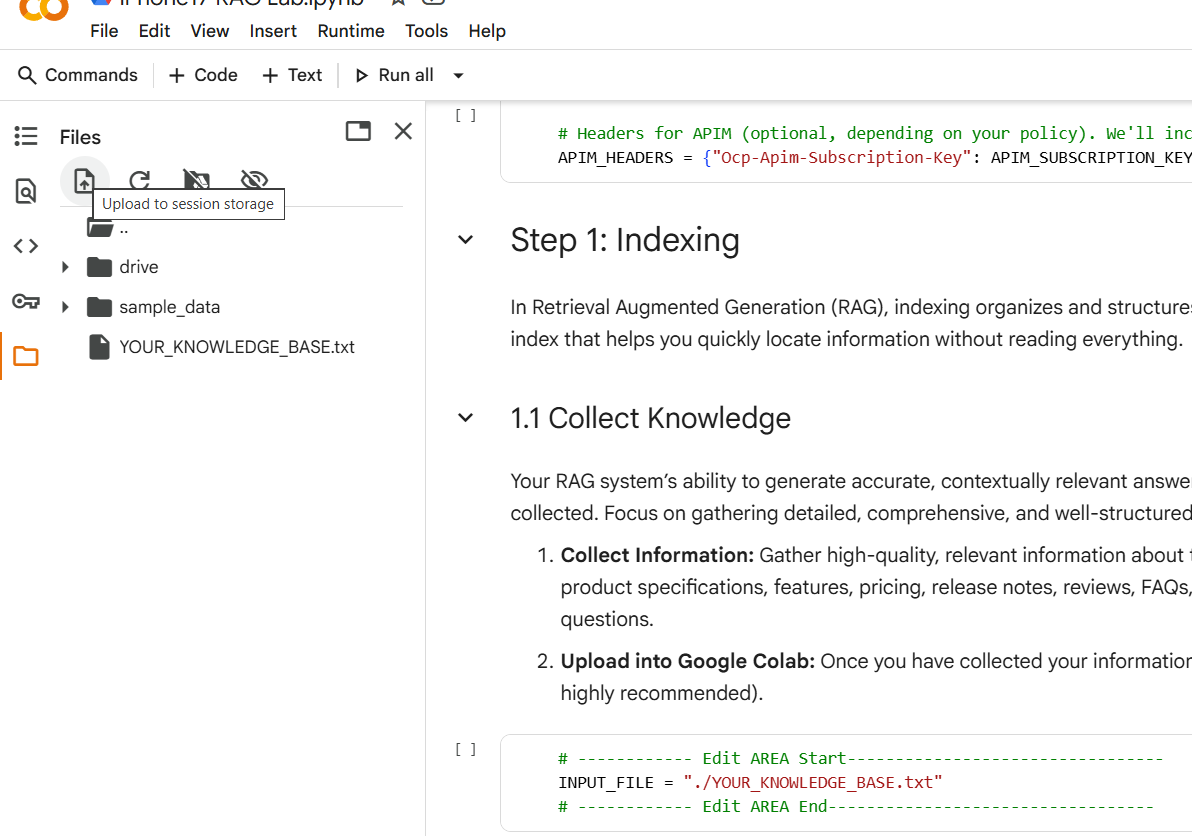

In [129]:
# ------------ Edit AREA Start---------------------------------
# 1. Collect your own knowledge base.
# 2. Organize it into a .TXT file.
# 3. Upload the .TXT file into this Colab.

INPUT_FILE = "./RAG Data.txt"
# ------------ Edit AREA End----------------------------------

### **1.2 Ingest & Clean**

This step involves gathering your raw data (ingestion) and processing it to make it suitable for the next steps in the RAG pipeline (cleaning). This process ensures that you have clean, relevant text data to work with for chunking and embedding.

In [130]:
# ------------ Edit AREA Start---------------------------------
# Implement raw_knowledge_base
# You should use load_text_from_file function to load text for your knowledge base .TXT file
# The variable should be INPUT_FILE

raw_knowledge_base = load_text_from_file(INPUT_FILE)
print(f"Loaded {len(raw_knowledge_base)} characters from {INPUT_FILE}")

# ------------ Edit AREA End---------------------------------


Loaded 152797 characters from ./RAG Data.txt


### **1.3 Chunk**

The following code demonstrates the chunking step, which breaks large text documents into smaller, manageable pieces. This process is **crucial** for RAG because large documents can be too long for the language model to process effectively.

In [131]:
!pip install -U langchain-text-splitters


In [132]:
# We'll use tools from LangChain to do this easily.
from langchain_text_splitters import RecursiveCharacterTextSplitter
# or
from langchain_text_splitters import CharacterTextSplitter

from langchain_core.documents import Document


# First, we need to convert our string into a LangChain 'Document' object.
# This is a standard format that LangChain tools know how to work with.

docs = [Document(page_content=raw_knowledge_base)]

# ------------ Edit AREA Start---------------------------------
# You may research on your own to see how CHUNK_SIZE and CHUNK_OVERLAP effect RAG results.
CHUNK_SIZE=800
CHUNK_OVERLAP=150
# ------------ Edit AREA End---------------------------------

# ------------ Edit AREA Start---------------------------------
# Implement text_splitter and split_documents HERE
# You should use RecursiveCharacterTextSplitter and text_splitter.split_documents functions
# The variables of text_splitter are chunk_size and chunk_overlap
# The variable of split_documents is docs

text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)

split_documents = text_splitter.split_documents(docs)

print(f"Step 1.3: The knowledge base was split into {len(split_documents)} smaller Chunks. 📄 -> 📄📄📄")

print(split_documents[3].page_content)


# ------------ Edit AREA End---------------------------------

Step 1.3: The knowledge base was split into 278 smaller Chunks. 📄 -> 📄📄📄
In recent trading:
Bitcoin traded at about $89,000. Last week, the cryptocurrency had its worst weekly loss since February.
In Asia, Alibaba shares rallied, bolstering Hong Kong's Hang Seng Index. Japanese markets were shut for a holiday.
"
} ,


### **1.4 Embed**

This step involves converting the text chunks into numerical representations called embeddings.

In [133]:
# Let's import the necessary tools.
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

# ------------ Edit AREA Start---------------------------------
# Implement embeddings
# You should use AzureOpenAIEmbeddings function
# The variables are azure_endpoint, azure_deployment, api_version, openai_api_key, and default_headers
embeddings = AzureOpenAIEmbeddings(
    azure_endpoint=AZURE_OPENAI_BASE,
    azure_deployment=EMBED_DEPLOYMENT,
    api_version=EMBED_API_VERSION,
    openai_api_key=AZURE_OPENAI_API_KEY,
    default_headers=APIM_HEADERS or None,
)

print("Step 1.4: Embedding has been created. All text chunks are now represented as numbers. 🔢")
# ------------ Edit AREA End---------------------------------

Step 1.4: Embedding has been created. All text chunks are now represented as numbers. 🔢


### **1.5 Store**

This step involves loading the embeddings and their associated text chunks into a specialized database designed for efficient searching, often called a **vector database**.

In [134]:
# ------------ Edit AREA Start---------------------------------
# Implement vector_store
# Use FAISS.from_documents function
# The variables are split_documents and embeddings
from langchain_community.vectorstores import FAISS
vector_store = FAISS.from_documents(split_documents, embeddings)

CHUNK_TEXT_OUT = "HW_2.txt"

with open(CHUNK_TEXT_OUT, "w", encoding="utf-8") as f:
    for i, d in enumerate(docs):
        f.write(f"===== CHUNK {i} =====\n")
        f.write(d.page_content)
        f.write("\n\n")

        vec = embeddings.embed_query(d.page_content)

        f.write("VECTOR:\n")
        f.write(str([vec]))
        f.write("\n\n")


# ------------ Edit AREA End---------------------------------

## **Step 2: Retrieval**

The Retrieval step finds the most relevant information in the vector database to answer a user's query. The process is as follows:

1.  **Encode the user query** into a vector using the same embedding model that was used on the documents.
2.  **Compute similarity scores** (e.g., cosine similarity) between the query vector and all the document chunk vectors in the database.
3.  **Retrieve the "Top-K"** (a predefined number) of the most similar chunks to use as the context for the final answer generation.


In [135]:
# ------------ Edit AREA Start---------------------------------
# Implement retriever
# You should use vector_store.as_retriever function
# You can modify the parameter top-K to determine how many revelant chunks are retrieved.
# You can play with the TOP-K parameter and see how it affects RAG results.

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

print("Step 2: The retriever is ready to find relevant information. 🔍")
# ------------ Edit AREA End---------------------------------


Step 2: The retriever is ready to find relevant information. 🔍


In [136]:
# ------------ Edit AREA Start---------------------------------
# You can design a revelant test question to test if your retriever works well.
retriever_test_question="How much did the S&P500 rise after President Trump said he had a good call with President Xi"


retrieved_docs = retriever.invoke(retriever_test_question)
# ------------ Edit AREA End---------------------------------

# Print the retrieval results
print("\n--- Retriever Test ---")
print(f"Found {len(retrieved_docs)} relevant documents for the test query.")
print(f"Most relevant document content: \n...{retrieved_docs[0].page_content}...")
print("--- End Test ---\n")


--- Retriever Test ---
Found 5 relevant documents for the test query.
Most relevant document content: 
..."I think he’s going to very much surprise you on the upside,” Trump told reporters.
Trump touted the call as "very good," and said he had accepted an invitation to visit Beijing in April and that Xi would reciprocate with a visit to the US later next year.
Trump: Revenue will 'skyrocket'
The White House is quietly preparing a backup plan as the US Supreme Court is set to decide whether Trump had the authority to issue them in the first place. Trump on Monday claimed the "full benefit" of tariff policies would take effect soon, arguing that foreign buyers who stockpiled inventory would be forced to buy more goods....
--- End Test ---



## **Step 3: Generation**

The final step, Generation, uses a language model to synthesize a coherent answer from the user's query and the retrieved information.

1.  **Build the Prompt:** The user's original query is combined with the retrieved text chunks to create a comprehensive prompt for the language model.

2.  **Construct RAG Pipeline:** We assemble the vector store, retriever, prompt and LLMs into a workflow.

3.  **Answer Generation:** The language model generates a final answer that is grounded in the retrieved documents. This "augmented" approach reduces the risk of factual errors or "hallucinations," leading to more accurate, contextually relevant responses.

### **3.1 Build the Prompt**

Building the prompt is the step where the user's query and the retrieved documents are combined into a single, clear instruction for the language model. In Lecture 5 (Prompt Engineering), we introduced a comprehensive prompt template:

```
* ROLE: <optional persona/audience>
* INSTRUCTION: <what to do>
* CONTEXT: <facts/tables/passage to use>
* INPUT: <the specific text/question>
* OUTPUT FORMAT: <exact schema or example of final output>
* CONSTRAINTS: <length, style, units, banned words>
* CHECKS:
    - If missing info → reply INSUFFICIENT.
    - Validate format before emitting.
```

In [137]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser


# ------------ Edit AREA Start---------------------------------
# Create your own Prompt for Custom Service Assistant Tasks
PROMPT_TEMPLATE ="""
ROLE:
You are a helpful assistant for summarizing relevant news articles based on user preference of either a focus on finance, politics, or tech.

INSTRUCTION:
Use the following retrieved context to answer the question.

Always output 10-20 sentences from the context unless otherwise specified.

Always output the titles of the articles from which you retrieved the information.

RESPONSE PROTOCOL:
If the answer is not in the context, say you don't have that information.

CONTEXT:
{context}

QUESTION:
{question}
"""

PROMPT = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
# ------------ Edit AREA End---------------------------------

llm = init_chat_model(
    model=CHAT_MODEL_NAME,
    model_provider="azure_ai",
    endpoint=AZURE_INFERENCE_BASE,
    credential=AZURE_INFERENCE_API_KEY,
    api_version=CHAT_API_VERSION,
    client_kwargs={"headers": APIM_HEADERS} if APIM_HEADERS else None,
)

### **3.2 Construct RAG Pipeline**

The RAG pipeline connects all the components—vector store, retriever, prompt, and LLM—into a unified workflow that efficiently processes queries and generates grounded answers.

A typical RAG pipeline operates as follows:

1. **Query Input:** The user's question is sent to the retriever.
2. **Retrieve Context:** The retriever fetches relevant documents or text chunks from the vector store.
3. **Format Prompt:** The retrieved context, along with the user’s question, is filled into a structured prompt template.
4. **Generate Answer:** The prompt is passed to the LLM, which synthesizes a response based on the provided context.
5. **Output Parsing:** The generated text is optionally cleaned or formatted for delivery.

In [138]:
# This function helps format the retrieved documents into a single block of text.
def format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)


# Here's how our chain will work:
# 1. The user's question comes in.
# 2. The `retriever` gets the question and finds the relevant context.
# 3. The `prompt` template gets the context and the original question.
# 4. The `llm` gets the filled-in prompt and generates the answer.
# 5. The `StrOutputParser` cleans up the LLM's output into a simple string.


# ------------ Edit AREA Start---------------------------------
# Implement rag_chain

rag_chain = (
    # retriever and user questions
    # minor: RunnablePassthrough is an identity block; returns whatever you give it unchanged
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | PROMPT # prompt template
    | llm # refer to the llm we will use
    | StrOutputParser() # Output format/clean
)

print("Step 3.2: The RAG pipeline has been created. We're ready to answer questions! ✅")

# ------------ Edit AREA End---------------------------------

Step 3.2: The RAG pipeline has been created. We're ready to answer questions! ✅


### **3.3 Generation**

Now that we have the prompt, which includes the user's query and the relevant context retrieved from our documents, we can use a language model to generate an answer.

Try to ask revelant questions that can be answered using the knowledge base you provided.

In [139]:
# ------------ Edit AREA Start---------------------------------
# Design test questions to test your rag_chain

test_question="How much did the S&P500 rise after President Trump said he had a good call with President Xi"
# ------------ Edit AREA End---------------------------------

response = rag_chain.invoke(test_question)
print(response)

The S&P 500 rose about 1.5% after President Trump posted on social media that he had a "very good telephone call with President Xi" and planned to visit China in April.


#### **Generation without RAG**

You can use following code cell to generate response without RAG. Compare two responses and see how greatly RAG improves LLMs' outputs.

In [140]:
# 1. Create Non-RAG prompt template
NON_RAG_PROMPT_TEMPLATE = """
QUESTION:
{question}

Please answer the user's question based on your general knowledge.
"""

NON_RAG_PROMPT = ChatPromptTemplate.from_template(NON_RAG_PROMPT_TEMPLATE)

# 2. Chain them together.
non_rag_chain = NON_RAG_PROMPT | llm | StrOutputParser()

# 3. Generate answer to your test question without RAG
non_rag_response = non_rag_chain.invoke(test_question)
print(non_rag_response)



I don't have real-time or specific post-event stock market data, so I can't provide the exact amount the S&P 500 rose after President Trump announced he had a good call with President Xi. However, during periods of positive diplomatic news or perceptions of progressing trade negotiations between the U.S. and China, the stock market, including the S&P 500, often experienced gains. For precise figures, you would need to consult historical market data corresponding to the specific date of the announcement.


## **Evaluate Your RAG system**

Now you succesfully built your own RAG system. You need to act as a Costum Service Assistant to answer 12 questions below about your policy.

**Note:** You may update your existing knowledge base .TXT to supplement product information. Please remember to **re-run the cell you modified and all subsequent cells** to ensure your Colab notebook reflects the changes correctly.

In [154]:
import json
# Evaluation questions
evaluate_questions=[
"""Can you summarize finance and political news from the past week?""",
]

results=[]
all_kpis = []

# Thresholds to inspect (will show effect of threshold choice)
inspect_thresholds = [0.75, 0.70, 0.65, 0.60]

def _print_threshold_table(max_sims, thresholds):
    print('\nPer-threshold hit rates:')
    for thr in thresholds:
        hits = [1 if s >= thr else 0 for s in max_sims]
        hr = sum(hits)/len(hits) if len(hits)>0 else 0.0
        print(f"  Threshold {thr:.2f}: {hr:.2%} ({sum(hits)}/{len(hits)})")

# Generation + KPI computation with diagnostics
for question in evaluate_questions:
  print('\n=== QUESTION ===')
  print(question)

  # Explicit retrieval so we can compute KPIs against the same retrieved texts
  retrieved_docs = retriever.invoke(question)
  retrieved_texts = [d.page_content for d in retrieved_docs]
  print(f"Retrieved {len(retrieved_texts)} documents")

  # Generate the response via the RAG chain
  response = rag_chain.invoke(question)

  # Compute Retrieval Hit Rate KPI (this returns per-sentence max similarities)
  rhr_kpi = retrieval_hit_rate_by_similarity(response, retrieved_texts, sim_threshold=0.6)

  # Compute Top-K Recall KPI (what fraction of retrieved docs are relevant to the query)
  tkr_kpi = compute_top_k_recall(question, retrieved_texts, sim_threshold=0.5, k=len(retrieved_texts))

  # If RHR had an error, surface it and skip detailed diagnostics
  if rhr_kpi.get('hit_rate') is None:
      print('\nRetrieval Hit Rate: ERROR computing KPI ->', rhr_kpi.get('error'))
      results.append({
            "question": question,
            "response": response,
            "retrieval_hit_rate": None,
            "error": rhr_kpi.get('error')
        })
      continue

  # Diagnostics: per-sentence similarities and matched doc snippets
  max_sims = rhr_kpi['max_similarities']
  best_idxs = rhr_kpi.get('best_doc_idx', [])
  sentences = rhr_kpi['sentences']

  print('\nResponse:\n', response)
  print(f"\nComputed {len(sentences)} sentences in the response.")
  print('\nPer-sentence diagnostics:')
  for i, sent in enumerate(sentences):
      sim = max_sims[i] if i < len(max_sims) else 0.0
      best = best_idxs[i] if i < len(best_idxs) else None
      snippet = retrieved_texts[best][:200].replace('\n',' ') if (best is not None and best < len(retrieved_texts)) else ''
      print(f"[{i}] sim={sim:.3f} best_doc={best} snippet='{snippet[:120]}'")
      print(f"     sent: {sent}\n")

  # Show hit rates for several thresholds so you can see why 0% occurred
  _print_threshold_table(max_sims, inspect_thresholds)

  # Print Retrieval Hit Rate
  print(f"\n[RHR] Retrieval Hit Rate: {rhr_kpi.get('hit_rate'):.2%} ({len(sentences)} sentences)")

  # Print Top-K Recall
  if tkr_kpi.get('recall') is not None:
      print(f"[Top-K Recall] {tkr_kpi['recall']:.2%} ({tkr_kpi['num_relevant_in_topk']}/{tkr_kpi['total_docs']} retrieved docs are semantically relevant)")
      print(f"  Doc similarities: {[round(x, 3) for x in tkr_kpi['doc_similarities']]}")
  else:
      print(f"[Top-K Recall] ERROR: {tkr_kpi.get('error')}")

  # Use default threshold (0.75) for RHR and 0.70 for Top-K Recall as the KPI stored in results
  results.append({
        "question": question,
        "response": response,
        "retrieval_hit_rate": rhr_kpi.get('hit_rate'),
        "num_sentences": rhr_kpi.get('num_sentences'),
        "per_sentence_max_similarities": rhr_kpi.get('max_similarities'),
        "per_sentence_hits_at_0.5": rhr_kpi.get('hits'),
        "top_k_recall": tkr_kpi.get('recall'),
        "top_k_recall_relevant_count": tkr_kpi.get('num_relevant_in_topk'),
        "top_k_recall_total_docs": tkr_kpi.get('total_docs'),
        "doc_similarities": tkr_kpi.get('doc_similarities')
    })

  all_kpis.append(rhr_kpi)

# Print JSON summary and aggregate metrics
print('\n==== SUMMARY JSON ====')
print(json.dumps(results, indent=2, ensure_ascii=False))

# Compute and print aggregates
valid_rhr = [k['hit_rate'] for k in all_kpis if k.get('hit_rate') is not None]
valid_tkr = [r.get('top_k_recall') for r in results if r.get('top_k_recall') is not None]

print('\n==== AGGREGATE METRICS ====')
if valid_rhr:
    avg_rhr = sum(valid_rhr)/len(valid_rhr)
    print(f"Average Retrieval Hit Rate: {avg_rhr:.2%}")
else:
    print("Average Retrieval Hit Rate: N/A (no valid data)")

if valid_tkr:
    avg_tkr = sum(valid_tkr)/len(valid_tkr)
    print(f"Average Top-K Recall: {avg_tkr:.2%}")
else:
    print("Average Top-K Recall: N/A (no valid data)")



=== QUESTION ===
Can you summarize finance and political news from the past week?
Retrieved 5 documents

Response:
 Certainly. Here is a summary of finance and political news from the past week based on the retrieved articles:

**Finance News:**
- A fundamental shift is underway in the global investment landscape, influenced by persistent inflation and high interest rates. The recent market focus has been on the U.S. Federal Reserve's upcoming interest rate decision, with traders dramatically re-pricing their expectations. The market now perceives a less-than-even chance of a US interest rate cut scheduled for December 10.
- The flow of crucial economic data from the U.S. has been disrupted, with key reports on employment, inflation (Consumer Price Index), and consumer spending possibly never being released. This data gap has heightened uncertainty among investors, policymakers, and households.
- The scenario reflects a new era of financial prudence, with central banks unlikely to rev